In [10]:
import itertools
import os
import pickle
import random
from multiprocessing import Pool
from typing import Any, Callable, Dict, Iterable, Iterator, List, Optional, Tuple, Union

# import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler, WeightedRandomSampler
from tqdm import tqdm

from replay_loading import enum_replay_folder, files_to_strokes, sample_stroke

%matplotlib inline
plt.style.use("ggplot")

In [2]:
replay_fns = list(itertools.islice(enum_replay_folder("H:/osu!/Data/r/"), 300))
strokes_subset = list(files_to_strokes(tqdm(replay_fns), min_length=50))
sum((len(s[0]) for s in strokes_subset))

100%|██████████| 300/300 [00:16<00:00, 17.94it/s]


1940603

In [3]:
# all_replays = list(enum_replay_folder("H:/osu!/Data/r/"))
# all_strokes = list(files_to_strokes(tqdm(all_replays), min_length=50))
# pickle.dump(all_strokes, open("all_strokes.pkl", "wb"))

In [4]:
all_strokes = pickle.load(open("all_strokes.pkl", "rb"))

In [5]:
class StrokeDataset(Dataset):
    def __init__(self, strokes, transforms=None):
        self.strokes = strokes
        self.transforms = transforms
        self.wrand_sampler = WeightedRandomSampler([len(s[0]) for s in strokes], len(strokes), replacement=True)

    def __len__(self):
        return len(self.strokes)

    def __getitem__(self, idx):
        sample = self.strokes[idx]
        
        # Apply the transformations if any
        if self.transforms:
            for transform in self.transforms:
                sample = transform(sample)
            return sample
        else:
            return sample[1]


class StrokeResample:
    def __init__(self, rate_range=(30, 250), max_length=2048):
        self.rate_range = rate_range
        self.max_length = max_length

    def __call__(self, sample):
        timings, positions = sample
        rate = np.random.uniform(*self.rate_range)
        offset = np.random.uniform(0, 1/rate)
        return sample_stroke(timings, positions, rate, offset, max_length=self.max_length)


class StrokeDiff:
    def __call__(self, sample):
        return np.diff(sample, axis=0)


class ScaleRotateFlip:
    def __init__(self, scale_range=(0.5, 1.5)):
        self.scale_range = scale_range

    def __call__(self, sample):
        scale = random.uniform(*self.scale_range)
        sample = sample * scale
        angle = random.uniform(-np.pi, np.pi)
        flip = random.choice([1, -1])
        rotation_matrix = np.array([
            [np.cos(angle), -flip * np.sin(angle)],
            [flip * np.sin(angle), np.cos(angle)]])
        sample = sample @ rotation_matrix
        return sample


class StrokeToTensor:
    def __call__(self, sample):
        return torch.from_numpy(sample).float()


def collate_pad_beginning_zeroes(batch):
    max_len = max([len(stroke) for stroke in batch])
    padded_batch = [F.pad(stroke, (0, 0, max_len - len(stroke), 0)) for stroke in batch]
    return torch.stack(padded_batch)


transforms = [
    StrokeResample(max_length=4096),
    StrokeDiff(),
    ScaleRotateFlip(),
    StrokeToTensor(),
]

batch_size = 1024

ds_small = StrokeDataset(strokes_subset, transforms=transforms)
ds_small_loader = DataLoader(ds_small, batch_size=batch_size, sampler=ds_small.wrand_sampler, collate_fn=collate_pad_beginning_zeroes)

ds_full = StrokeDataset(all_strokes, transforms=transforms)
ds_full_loader = DataLoader(ds_full, batch_size=batch_size, sampler=ds_full.wrand_sampler, collate_fn=collate_pad_beginning_zeroes)

In [124]:
class TestNet3(nn.Module):
    def __init__(
        self, kernels=[5] * 12, channels=[8] * 4 + [4] * 4 + [2] * 4, dilations=[1] * 12
    ):
        super().__init__()

        self.kernels = torch.tensor(kernels + [1])
        self.channels = torch.tensor(channels + [2])
        self.in_channels = torch.tensor([2] + channels).cumsum(dim=0)
        self.total_channels = self.in_channels[-1].item() + 2
        self.dilations = torch.tensor(dilations + [1])
        self.pads = [
            (kernel - 1) * dilation
            for kernel, dilation in zip(self.kernels, self.dilations)
        ]
        self.pad_total = sum(self.pads).item()
        self.ar_len = None

        # print(f"Kernels: {self.kernels} {self.kernels.shape}")
        # print(f"Input channels: {self.in_channels} {self.in_channels.shape}")
        # print(f"Channels: {self.channels} {self.channels.shape}")
        # print(f"Dilations: {self.dilations} {self.dilations.shape}")
        # print(f"Pads: {self.pads} {self.pads.shape}")
        # print(f"Total padding: {self.pad_total}")

        self.convs = nn.ModuleList(
            [
                nn.Conv1d(
                    in_channels=self.in_channels[i].item(),
                    out_channels=self.channels[i].item() * 2,
                    kernel_size=self.kernels[i].item(),
                    dilation=self.dilations[i].item(),
                )
                for i in range(len(self.kernels))
            ]
        )

    def forward(self, x):
        # input is (batch, seq_len, 2)
        # x = x.mT  # (batch, 2, seq_len)
        batch_size = x.shape[0]
        seq_len = x.shape[-1]
        if self.ar_len is None:
            acts = torch.empty(
                batch_size, self.total_channels, seq_len, device=x.device
            )
            acts[..., :2, :] = x
            curr_window = seq_len
            for i, conv in enumerate(self.convs):
                channel_start = self.in_channels[i].item()
                channel_end = channel_start + self.channels[i].item()
                x = acts[..., :channel_start, -curr_window:]
                x = conv(x)
                x = F.glu(x, dim=-2)
                curr_window -= self.pads[i]
                acts[
                    ...,
                    channel_start:channel_end,
                    -curr_window:,
                ] = x
            return acts[..., -2:, -curr_window:]  # .mT
        else:
            acts = torch.empty(
                batch_size,
                self.total_channels,
                seq_len + self.ar_len - 1,
                device=x.device,
            )
            acts[..., :2, :seq_len] = x
            # first pass
            curr_window = seq_len
            for i, conv in enumerate(self.convs):
                channel_start = self.in_channels[i]
                channel_end = channel_start + self.channels[i]
                x = acts[..., :channel_start, seq_len - curr_window : seq_len]
                x = conv(x)
                x = F.glu(x, dim=-2)
                curr_window -= self.pads[i]
                acts[
                    ...,
                    channel_start:channel_end,
                    seq_len - curr_window : seq_len,
                ] = x
            # later autoregressive passes
            for ar_step in range(1, self.ar_len):
                step_col = ar_step - self.ar_len
                acts[..., :2, step_col] = acts[..., -2:, step_col - 1]
                for i, conv in enumerate(self.convs):
                    channel_start = self.in_channels[i]
                    channel_end = channel_start + self.channels[i]
                    x = acts[
                        ...,
                        :channel_start,
                        step_col - self.pads[i] - 1 : step_col,
                    ]
                    x = conv(x)
                    x = F.glu(x, dim=-2)
                    acts[
                        ...,
                        channel_start:channel_end,
                        step_col : step_col + 1,
                    ] = x
            return acts[..., -2:, -self.ar_len :]  # .mT


sum(p.numel() for p in TestNet3().parameters() if p.requires_grad)

15468

In [140]:
for i in torch.rand(5, 5):
    print(i)

tensor([0.2276, 0.7897, 0.7854, 0.4141, 0.3337])
tensor([0.2103, 0.5353, 0.6915, 0.1386, 0.8969])
tensor([0.3024, 0.9456, 0.0404, 0.8617, 0.9429])
tensor([0.3049, 0.6746, 0.9541, 0.7280, 0.6335])
tensor([0.2845, 0.6857, 0.4670, 0.2040, 0.1037])


In [53]:
smaller_params = {
    "kernels": [8, 6, 4, 3, 2],
    "channels": [2]*5
}

smaller_model = TestNet3(**smaller_params)

sum(p.numel() for p in smaller_model.parameters() if p.requires_grad), smaller_model.pad_total

Kernels: tensor([8, 6, 4, 3, 2, 1]) torch.Size([6])
Input channels: tensor([ 2,  4,  6,  8, 10, 12]) torch.Size([6])
Channels: tensor([2, 2, 2, 2, 2, 2]) torch.Size([6])
Dilations: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]) torch.Size([13])
Total padding: 18


(504, tensor(18))

In [54]:
small_params = {
    "kernels": [5]*6,
    "channels": [2]*6,
    "dilations": [1, 2, 3, 4, 2, 1]
}

small_model = TestNet3(**small_params)

sum(p.numel() for p in small_model.parameters() if p.requires_grad), small_model.pad_total

Kernels: tensor([5, 5, 5, 5, 5, 5, 1]) torch.Size([7])
Input channels: tensor([ 2,  4,  6,  8, 10, 12, 14]) torch.Size([7])
Channels: tensor([2, 2, 2, 2, 2, 2, 2]) torch.Size([7])
Dilations: tensor([1, 2, 3, 4, 2, 1, 1]) torch.Size([7])
Total padding: 52


(924, tensor(52))

In [52]:
dilated2_params = {
    "kernels": [5]*7,
    "channels": [4, 4, 3, 3, 2, 2, 2],
    "dilations": [1, 2, 3, 4, 3, 2, 1]
}

dilated2_model = TestNet3(**dilated2_params)

sum(p.numel() for p in dilated2_model.parameters() if p.requires_grad), dilated2_model.pad_total

Kernels: tensor([5, 5, 5, 5, 5, 5, 5, 1]) torch.Size([8])
Input channels: tensor([ 2,  6, 10, 13, 16, 18, 20, 22]) torch.Size([8])
Channels: tensor([4, 4, 3, 3, 2, 2, 2, 2]) torch.Size([8])
Dilations: tensor([1, 2, 3, 4, 3, 2, 1, 1]) torch.Size([8])
Total padding: 64


(2222, tensor(64))

In [200]:
small_model.pads

[4, 8, 12, 16, 8, 4, 0]

In [214]:
# model = TestNet3().cuda()
# model = smaller_model.cuda()
# model = small_model.cuda()
model = dilated2_model.cuda()
unpad = model.pad_total + 1
optimizer = optim.AdamW(model.parameters(), lr=0.002)

losses = []
losses_verbose = []

Epoch 1, Loss: 0.5229712479735074, LR: 0.002
Epoch 2, Loss: 0.3821570545298868, LR: 0.0019782568627301367
Epoch 3, Loss: 0.3689375013521273, LR: 0.001913977730354388
Epoch 4, Loss: 0.36065788968513, LR: 0.0018099719094030729
Epoch 5, Loss: 0.35650813021616307, LR: 0.001670784953327064
Epoch 6, Loss: 0.3537160140466472, LR: 0.0015025000000000001
Epoch 7, Loss: 0.3478739497051936, LR: 0.001312471909403073
Epoch 8, Loss: 0.35018712132488755, LR: 0.0011090058209513155
Epoch 9, Loss: 0.34653664955265445, LR: 0.0009009941790486852
Epoch 10, Loss: 0.34713985821972154, LR: 0.0006975280905969276
Epoch 11, Loss: 0.3446148657091132, LR: 0.0005075000000000004
Epoch 12, Loss: 0.3462069177464263, LR: 0.0003392150466729365
Epoch 13, Loss: 0.3435532592202975, LR: 0.0002000280905969274
Epoch 14, Loss: 0.3437256664718123, LR: 9.602226964561204e-05
Epoch 15, Loss: 0.34169955517603384, LR: 3.174313726986335e-05


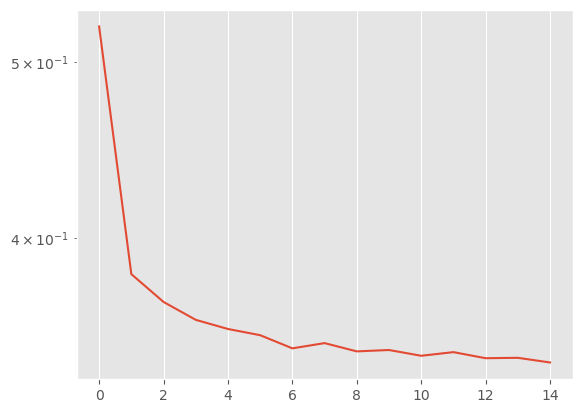

In [215]:
n_epochs = 15
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs, eta_min=0.00001)

for epoch in range(n_epochs):  # number of epochs
    epoch_losses = []

    for batch in ds_full_loader:
        # Zero the gradients
        optimizer.zero_grad()

        batch = batch.cuda()

        # Forward pass
        outputs = model(batch[:, :-1, :])

        # Compute loss
        loss = F.huber_loss(outputs, batch[:, unpad:, :])

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())
    
    epoch_loss = np.mean(epoch_losses)
    losses.append(epoch_loss)
    losses_verbose.append(epoch_losses)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss}, LR: {scheduler.get_last_lr()[0]}")

    # Update the learning rate
    scheduler.step()

plt.plot(losses)
plt.yscale('log')

In [125]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [219]:
model.cpu()
# torch.save(model.state_dict(), "model1.pth")

TestNet3(
  (convs): ModuleList(
    (0): Conv1d(2, 8, kernel_size=(5,), stride=(1,))
    (1): Conv1d(6, 8, kernel_size=(5,), stride=(1,), dilation=(2,))
    (2): Conv1d(10, 6, kernel_size=(5,), stride=(1,), dilation=(3,))
    (3): Conv1d(13, 6, kernel_size=(5,), stride=(1,), dilation=(4,))
    (4): Conv1d(16, 4, kernel_size=(5,), stride=(1,), dilation=(3,))
    (5): Conv1d(18, 4, kernel_size=(5,), stride=(1,), dilation=(2,))
    (6): Conv1d(20, 4, kernel_size=(5,), stride=(1,))
    (7): Conv1d(22, 4, kernel_size=(1,), stride=(1,))
  )
)

In [141]:
# torch.save(model.state_dict(), "dilated2_model.pth")
model = TestNet3(**dilated2_params)
model.load_state_dict(torch.load("dilated2_model.pth"))
model, model.pad_total

(TestNet3(
   (convs): ModuleList(
     (0): Conv1d(2, 8, kernel_size=(5,), stride=(1,))
     (1): Conv1d(6, 8, kernel_size=(5,), stride=(1,), dilation=(2,))
     (2): Conv1d(10, 6, kernel_size=(5,), stride=(1,), dilation=(3,))
     (3): Conv1d(13, 6, kernel_size=(5,), stride=(1,), dilation=(4,))
     (4): Conv1d(16, 4, kernel_size=(5,), stride=(1,), dilation=(3,))
     (5): Conv1d(18, 4, kernel_size=(5,), stride=(1,), dilation=(2,))
     (6): Conv1d(20, 4, kernel_size=(5,), stride=(1,))
     (7): Conv1d(22, 4, kernel_size=(1,), stride=(1,))
   )
 ),
 64)

In [126]:
model = TestNet3()
model.load_state_dict(torch.load("model1.pth"))
model, model.pad_total

(TestNet3(
   (convs): ModuleList(
     (0): Conv1d(2, 16, kernel_size=(5,), stride=(1,))
     (1): Conv1d(10, 16, kernel_size=(5,), stride=(1,))
     (2): Conv1d(18, 16, kernel_size=(5,), stride=(1,))
     (3): Conv1d(26, 16, kernel_size=(5,), stride=(1,))
     (4): Conv1d(34, 8, kernel_size=(5,), stride=(1,))
     (5): Conv1d(38, 8, kernel_size=(5,), stride=(1,))
     (6): Conv1d(42, 8, kernel_size=(5,), stride=(1,))
     (7): Conv1d(46, 8, kernel_size=(5,), stride=(1,))
     (8): Conv1d(50, 4, kernel_size=(5,), stride=(1,))
     (9): Conv1d(52, 4, kernel_size=(5,), stride=(1,))
     (10): Conv1d(54, 4, kernel_size=(5,), stride=(1,))
     (11): Conv1d(56, 4, kernel_size=(5,), stride=(1,))
     (12): Conv1d(58, 4, kernel_size=(1,), stride=(1,))
   )
 ),
 48)

In [143]:
x = torch.zeros(1, model.pad_total + 1, 2)
x[:, -2, :] = torch.tensor([-0.05, 0.05])
x[:, -1, :] = torch.tensor([-0.1, 0.1])
x = x.mT

model.ar_len = 5
res = model(x)
res, x.shape, res.shape

(tensor([[[-0.1185, -0.1185, -0.1229, -0.1314,  1.0971],
          [ 0.1132,  0.1132,  0.1163,  0.1011,  0.0000]]],
        grad_fn=<SliceBackward0>),
 torch.Size([1, 2, 65]),
 torch.Size([1, 2, 5]))

In [35]:
model.cpu()
x = x.cpu()

In [144]:
%timeit model(x)

7.6 ms ± 209 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [146]:
torch.jit.trace(model, x)

TestNet3(
  original_name=TestNet3
  (convs): ModuleList(
    original_name=ModuleList
    (0): Conv1d(original_name=Conv1d)
    (1): Conv1d(original_name=Conv1d)
    (2): Conv1d(original_name=Conv1d)
    (3): Conv1d(original_name=Conv1d)
    (4): Conv1d(original_name=Conv1d)
    (5): Conv1d(original_name=Conv1d)
    (6): Conv1d(original_name=Conv1d)
    (7): Conv1d(original_name=Conv1d)
  )
)

In [148]:
torch.onnx.export(model, x, "dilated2_ar5steps.onnx")

In [224]:
def autoregressive_call(x):
    res = x
    n = 5
    for i in range(n):
        res = torch.cat([res[:,1:,:], model(res)[:,-1:,:]], dim=1)
    return res[:, -n:, :]

In [ ]:
torch.onnx.export(autoregressive_call, x, "dilated2_ar.onnx")

In [225]:
autoregressive_call(x)

tensor([[[-0.1185,  0.1132],
         [-0.1234,  0.1060],
         [-0.1334,  0.1007],
         [-0.1505,  0.1039],
         [-0.1711,  0.1115]]], grad_fn=<SliceBackward0>)

In [ ]:
torch.export.export(model, (x,))

In [13]:
torch.onnx.export(model, x, "model1.onnx")#, verbose=True)

In [18]:
torch.onnx.export(model, torch.rand(4, 49, 2), "model2.onnx")

In [ ]:
torch.onnx.dynamo_export(model, x, export_options=torch.onnx.ExportOptions(dynamic_shapes=True)).save("model3.onnx")